## 12. Seq2seq으로 한영 번역기 만들기

### 1. 데이터 준비

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re

In [2]:
kor_text_file = "korean-english-park.train.ko"
eng_text_file = "korean-english-park.train.en"

In [3]:
# 데이터 읽어오기
def read_data(file_path):
    with open(file_path, "r") as f:
        raw = f.read().splitlines()

    print("Data Size:", len(raw))
    print("Example:")
    for sentence in raw[:5]:
        print(">>", sentence)

    return raw

In [4]:
kor_text = read_data(kor_text_file)
eng_text = read_data(eng_text_file)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
>> 그러나 이것은 또한 책상도 필요로 하지 않는다.
>> 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
>> 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.
>> Like all optical mice, But it also doesn't need a desk.
>> uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.
>> Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.


In [5]:
# 랜덤하게 문장을 추출하여 한영 번역 결과 확인
index = 27
print(kor_text[index])
print(eng_text[index])

어휘 :
The Geneva-based commission, in its annual study of the industry titled “World Robotics 2001,” said a record 100,000 robots were installed last year, up 25 percent on 1999.


#### 분석
- 한글과 영어의 번역 매칭이 맞지 않은 경우가 다수 발견됨

In [6]:
# 중복 제거
kor_text_cleaned = list(set(kor_text))
eng_text_cleaned = list(set(eng_text))
print("중복제거 후 문장 수: ", len(kor_text_cleaned), len(eng_text_cleaned))

중복제거 후 문장 수:  77591 75598


#### 분석
- 각각 중복 제거했을 때, 데이터 크기가 맞지 않는 문제가 있음 --> **pandas DataFrame으로 변환하고 drop_duplicates 이용**

In [7]:
# 데이터를 DataFrame으로 변환
data = pd.DataFrame({"kor": kor_text, "eng": eng_text})
print(f'데이터 크기: {len(data)}')

데이터 크기: 94123


In [8]:
# 중복 제거
data = data.drop_duplicates(subset=['kor'])
print(f'중복 제거 후 데이터 크기: {len(data)}')

중복 제거 후 데이터 크기: 77591


In [9]:
# 문장 단위 텍스트 전처리
def preprocess_sentence(sentence):
    # 소문자 변환
    sentence = sentence.lower()

    # 문장 부호 간 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    # 숫자 간 띄어쓰기
    sentence = re.sub(r"([0-9]+)", r" \1 ", sentence)
    
    # 알파벳 한글 간 띄어쓰기
    sentence = re.sub(r"([a-zA-Z]+)", r" \1 ", sentence)

    # 알파벳, 한글, 숫자, 문장부호를 제외한 모든 문자를 공백으로 대체
    sentence = re.sub("[^a-zA-Z0-9가-힣?.!,]", " ", sentence)

    # 빈 칸 반복되는 것 하나로 줄이기
    sentence = re.sub(r'[" "]+', " ", sentence)

    # 문장 앞 뒤 공백 자르기
    sentence = sentence.strip()

    return sentence

In [10]:
# 데이터셋 단위 전처리
def preprocess_data(data):
    kor = []
    eng = []
    for k, e in zip(data['kor'], data['eng']):
        kor.append(preprocess_sentence(k))
        eng.append(preprocess_sentence(e))

    return kor, eng

In [11]:
kor_text_preprocessed, eng_text_preprocessed = preprocess_data(data)

### 2. 한글 토큰화

In [12]:
# 형태소 분석기로 Mecab 이용
from konlpy.tag import Mecab

mecab = Mecab()

In [13]:
# 형태소 분석기 테스트
print(mecab.morphs(kor_text_preprocessed[0]))

['개인', '용', '컴퓨터', '사용', '의', '상당', '부분', '은', '이것', '보다', '뛰어날', '수', '있', '느냐', '?']


In [14]:
# 한글 토큰화 함수
# 형태소 분석기를 통해 분리된 토큰의 갯수가 지정된 갯수보다 작아야 말뭉치에 포함됨
# 영어는 띄어쓰기 단위로 분리하고, 시작 토큰과 종료 토큰이 추가됨
def tokenize(kor_data, eng_data, max_token_length):
    kor = []
    eng = []
    for (kor_sen, eng_sen) in zip(kor_data, eng_data):
        try:
            kor_token = mecab.morphs(kor_sen)
            eng_token = ("<start> " + eng_sen + " <end>").split(" ")
            if len(kor_token) < max_token_length:
                kor.append(kor_token)
                eng.append(eng_token)
        except:
            print(kor_sen, eng_sen)

    return kor, eng

In [15]:
# 한글의 최대 토큰 길이를 50
kor_corpus, eng_corpus = tokenize(kor_text_preprocessed, eng_text_preprocessed, 50)

#### 디버깅
- 아래와 같은 에러메시지
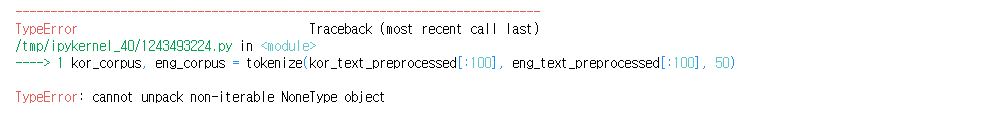
- tokenize() 함수의 리턴값이 없어서 발생하는 문제임

In [16]:
# 토큰 인덱스로 변환
def tokenize_index(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [17]:
enc_tensor, enc_tokenizer = tokenize_index(kor_corpus)
dec_tensor, dec_tokenizer = tokenize_index(eng_corpus)

### 3. 모델 설계

In [25]:
# 어텐션 함수
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)
        #print(context_vec.shape, attn.shape)

        return context_vec, attn

In [19]:
# 인코더
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [20]:
# 디코더
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

### 4. 훈련

In [21]:
# 옵티마이저
optimizer = tf.keras.optimizers.Adam()

In [22]:
# 손실 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [29]:
# 학습 스탭 정의
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        #print(enc_out.shape)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [30]:
# train_step을 호출하여 실제 모델 학습 수행 
from tqdm import tqdm
import random

#TRAIN_SAMPLE = len(enc_tensor)
TRAIN_SAMPLE = 30000
print(f'학습용 샘플 수: {TRAIN_SAMPLE}')
enc_train = enc_tensor[:TRAIN_SAMPLE]
dec_train = dec_tensor[:TRAIN_SAMPLE]

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 512
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE], dec_train[idx:idx+BATCH_SIZE], encoder, decoder, optimizer, dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

학습용 샘플 수: 30000


Epoch 10: 100%|██████████| 469/469 [05:12<00:00,  1.50it/s, Loss 1.9677]


#### 디버깅
- BATCH_SIZE: 64, units: 1024, embedding_dim: 512, TRAIN_SAMPLE: 72658 에서 메모리 부족 에러 발생
- BATCH_SIZE: 32, units: 512, embedding_dim: 256, TRAIN_SAMPLE: 72658 에서 학습시간 Epoch 당 19분 소요
- 학습이 완료되었거나, 강제 종료되어 다시 모델을 학습할 때 아래와 같은 에러 발생 -> train_step 함수를 다시 실행
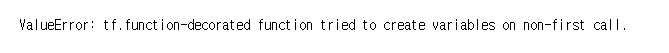
- BATCH_SIZE: 64, units: 512, embedding_dim: 256, TRAIN_SAMPLE: 30000 에서 학습시간 Epoch 당 6분 소요

### 5. 시각화

In [31]:
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'

#mpl.font_manager.findfont(font)
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')

In [32]:
# 어텐션 값을 시각화
def plot_attention(attention, sentence, predicted_sentence):
    print(attention.shape)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 10}

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

### 6. 평가

In [33]:
# 입력된 문장으로부터 디코더 출력을 얻어오는 함수 - 번역된 문장을 얻어온다
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
   
    #inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = mecab.morphs(sentence)
    inputs = enc_tokenizer.texts_to_sequences(inputs)
    print(inputs, type(inputs))

    res = []
    for element in inputs:
        res += element
    inputs = [res]
    print(inputs, type(res))

    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=enc_train.shape[-1], padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [34]:
# 번역과 어텐션 매트릭스 출력을 한 번에 처리하는 함수
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

[[264], [4], [7315], [3], [10183], [3], [2], [1], [6742], [8], [2203], [8], [2241], [2466], [3], [31770], [1265], [1568], [153], [5492], [1544], [7], [286], [6683], [34], [485], [35], [2], [1]] <class 'list'>
[[264, 4, 7315, 3, 10183, 3, 2, 1, 6742, 8, 2203, 8, 2241, 2466, 3, 31770, 1265, 1568, 153, 5492, 1544, 7, 286, 6683, 34, 485, 35, 2, 1]] <class 'list'>
Input: 그녀는 태생이 귀족이다 . 키드먼은 여러분은 왜 세상이 이토록 혼란스러운 때 아카데미상 시상식에 왔습니까 라고 물었다 .
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
(94, 17)


/tmp/ipykernel_31/1675387983.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/1675387983.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


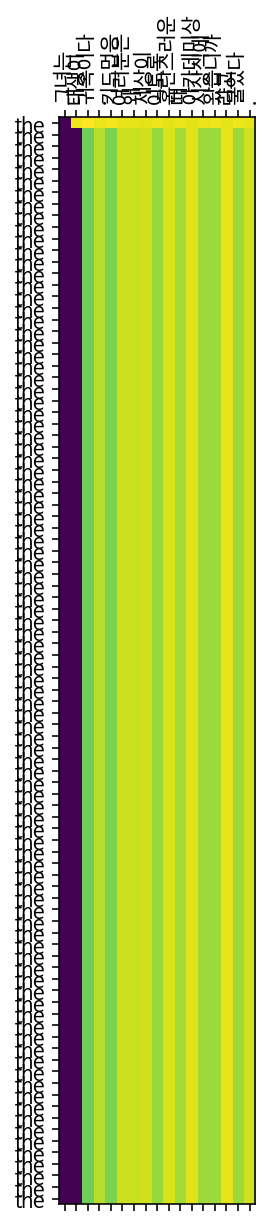

In [37]:
# 테스트 케이스 1 - 학습된 문장
test_index = 3269
translate(kor_text[test_index], encoder, decoder)

[[1010], [3098], [809], [439]] <class 'list'>
[[1010, 3098, 809, 439]] <class 'list'>
Input: 어떻게 지내니 ?
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
(94, 3)


/tmp/ipykernel_31/1675387983.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/1675387983.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


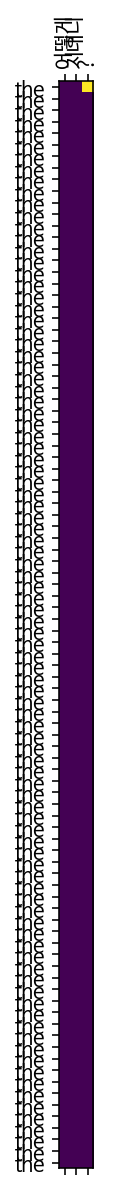

In [36]:
# 테스트 케이스 2 - 새로운 문장
translate("어떻게 지내니?", encoder, decoder)

#### 분석
- 정상적인 번역 결과를 출력하지 못함
- 정확한 원인 분석이 어려움
- 학습에 상당한 시간이 걸려서 모델 변경이나 파라미터 변경을 통한 반복적인 테스트 불가

- 작은 데이터셋으로 학습을 하면 아래와 같이 출력됨 --> 바로 종료 토큰을 전달
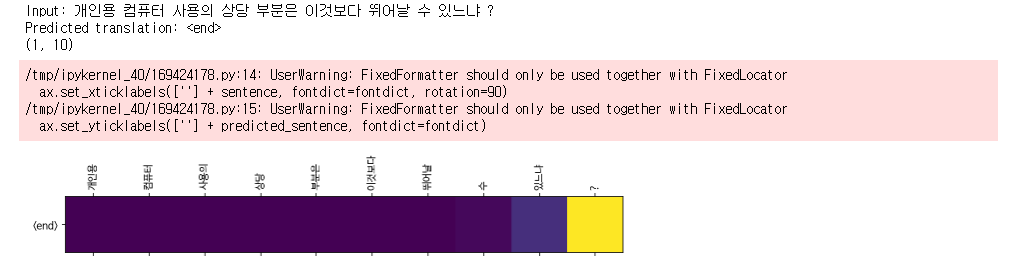

- 어텐션 그래프가 이상하게 표시되는 것은 폭(입력 시퀀스의 수)에 비해 높이(출력 시퀀스의 수)가 높아서 발생
- 히트맵을 구성하는 사각형이 정사각형으로 그려지도록 크기가 결정되어 폭이 좁은 그래프로 그려짐

### 회고

#### 성능이 나오지 않는 이유에 대한 생각

1) 학습에 사용된 한-영 번역 데이터의 품질이 매우 나쁨
- 한 줄이 하나의 완결된 문장이어서 1:1로 한-영 번역이 이뤄지는 구조가 아님.
- 개인적인 생각으로는 '여러 줄에 걸쳐 문단으로 구성된 한-영 번역 데이터를 복사/붙여넣기 해서 만들어진 데이터'라는 생각이 듬

2) 모델의 문제점을 확인하고 분석하기 어려움
- 학습에 상당한 시간이 걸림.
- 데이터 수를 줄이면 학습이 빨리 되지만, 번역 결과를 출력하지 못함.
- 모델 구조의 복잡성은 결국 모델의 한계점을 찾기 어렵게 함.
- 모델 동작 상태를 정확히 알 수 없는 상태에서 '레이어 추가/변경', '하이퍼파라미터 변경' 같은 전략이 어떠한 의미를 가지는지 판단하기 어려움
- '그냥 해보고, 되면 좋고, 아니면 또 해보고'는 연구자/엔지니어로써 좋은 방법론은 아닌 듯

#### 성능 향상 및 성능 평가 방법에 대한 생각
- 한글 문장 데이터를 파파고 등의 번역 서버스를 이용해서 라인 별로 영어로 번역하고, 이를 디코더 입력용으로 이용하는 방식이 좋을 것 같음.
- 학습된 번역 모델이 출력한 결과와 디코더 입력으로 사용한 데이터와의 차이를 비교하여 성능 평가 (n-gram 이용해서)

#### CV 팀과의 논의를 들으며
- 어텐션이 입력 시퀀스 상의 각 입력에 대해 어느 정도의 가중치를 가지는지를 나타내는 벡터라고 본다면, CV의 CAM과 gradCAM과 목적이 같은 것이라는 생각.
- 어텐션 vs CAM vs gradCAM 의 동작 원리에 대해 비교해보는 것도 좋을 것 같음